<a href="https://colab.research.google.com/github/kannankumar/jupyter-notebooks/blob/mnist/MNIST_Conditional_GAN_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Conditional DCGAN (Keras)
### Generating Handwritten Digits


In this notebook, we train a conditional DCGAN in Keras to generate handwritten digits(0-9).

This is the most basic dataset. It can't get simpler than this.It's embarassing to even publish this notebook.

-----
**Footnote**

This notebook is inspired from the book **GANs in Action** and it's accompanying [Notebooks](https://github.com/GANs-in-Action/gans-in-action/)

## 0. Load Required packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras

Using TensorFlow backend.


In [0]:
from keras.models import Sequential, Model
from keras.layers import Input,  Flatten, Reshape, Dense, Embedding
from keras.layers import Conv2D, Conv2DTranspose, Dropout 
from keras.layers import Multiply, Concatenate, Activation, BatchNormalization
from keras.optimizers import Adam
from keras.layers.advanced_activations import LeakyReLU

In [0]:
from keras.datasets import mnist

In [0]:
img_width = 28
img_height = 28
num_channels = 1

img_shape = (img_width, img_height, num_channels)

z_dim = 100
num_classes = 10

## 1. Define the Model Architecture

### 1.1. Generator

In [0]:
def build_generator(z_dim):
  model = Sequential()

  #100 -> 7x7x256
  model.add(Dense(7*7*256, input_dim=z_dim))
  model.add(Reshape((7,7,256)))
  
  # 7x7x256 -> 14x14x128
  model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.1))

  # 14x14x128 -> 14x14x64
  model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.1))

  # 14x14x64 -> 28x28x1
  model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))
  model.add(Activation('tanh'))  

  return model

In [0]:
# z_dim = 100
# n_classes = 10
# label = 7
# z = Input(shape=(z_dim,))
# print(z.shape)

# label = Input(shape=(1,), dtype='int32')
# print(label.shape)

# label_embedding = Embedding(n_classes, z_dim, input_length=1)(label)
# print(label_embedding.shape)

# label_embedding = Flatten()(label_embedding)
# print(label_embedding.shape)

# joined_representation = Multiply()([z,label_embedding])
# print(joined_representation.shape)

In [0]:
def build_cgan_generator(z_dim):
  z = Input(shape=(z_dim,))
  label = Input(shape=(1,), dtype='int32')

  label_embedding = Embedding(num_classes, z_dim, input_length=1)(label)
  label_embedding = Flatten()(label_embedding)

  joined_representation = Multiply()([z,label_embedding])

  generator = build_generator(z_dim)
  conditioned_img = generator(joined_representation)

  return Model([z,label],conditioned_img)

### 1.2. Discriminator

In [0]:
def build_discriminator(img_shape):
  model = Sequential()

  #28x28x1 -> 14x14x64
  model.add(Conv2D(64, kernel_size=3, strides=2, padding='same', 
                   input_shape=(img_shape[0], img_shape[1], img_shape[2]+1)))
  model.add(LeakyReLU(alpha=0.1)) 

  #14x14x64 -> 7x7x64
  model.add(Conv2D(64, kernel_size=3, strides=2, padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.1)) 

  # 7x7x64 -> 3x3x128
  model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.1))

  # 3x3x129 -> 3*3*128
  model.add(Flatten())

  # 3*3*128 -> 1
  model.add(Dense(1, activation='sigmoid'))
  
  return model

In [0]:
def build_cgan_discriminator(img_shape):
  img = Input(shape=(img_shape))

  label = Input(shape=(1,), dtype='int32')
  label_embedding = Embedding(num_classes, np.prod(img_shape), input_length=1)(label)
  label_embedding = Flatten()(label_embedding)
  label_embedding = Reshape(img_shape)(label_embedding)

  concatenated_input = Concatenate(axis=-1)([img, label_embedding])

  discriminator = build_discriminator(img_shape)
  classification = discriminator(concatenated_input)

  return Model([img, label], classification)

### 1.3 Full Conditional GAN model

In [0]:
def build_cgan(generator, discriminator):
  z = Input(shape=(z_dim,))
  label = Input(shape=(1,), dtype='int32')

  img = generator([z, label])
  classification = discriminator([img, label])

  return Model([z,label],classification)

## 2. Compile the Model

In [0]:
discriminator = build_cgan_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

generator = build_cgan_generator(z_dim)
discriminator.trainable = False

cgan = build_cgan(generator, discriminator)
cgan.compile(loss='binary_crossentropy', optimizer=Adam())

## 3. Training Loop

In [0]:
def train(iterations, batch_size, print_every, sample_every):
  # Load data
  (x_train, y_train), (_,_) = mnist.load_data()

  # Preproecess data to have range [-1,1]
  x_train = x_train / 255 
  x_train = x_train * 2 -1
  x_train = np.expand_dims(x_train, axis=3)

  # Create real and fake labels for a batch
  real_labels = np.ones((batch_size, 1))
  fake_labels = np.zeros((batch_size, 1))

  for iteration in range(iterations):
    #**********************************#
    #       Train Discriminator        #
    #**********************************#

    # Take a batch of real examples
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    train_imgs, train_labels = x_train[idx], y_train[idx]

    # Take a batch of random noise vectors
    z = np.random.normal(0,1, (batch_size, z_dim))

    # Generate a batch of fake images
    gen_imgs = generator.predict([z, train_labels])

    d_loss_real = discriminator.train_on_batch([train_imgs, train_labels], real_labels)
    d_loss_fake = discriminator.train_on_batch([gen_imgs, train_labels], fake_labels)
    d_loss = np.add(d_loss_real, d_loss_fake) * 0.5

    #**********************************#
    #         Train Generator          #
    #**********************************#
    
    # Take a batch of random noise vectors
    z = np.random.normal(0,1,(batch_size, z_dim))

    # Take a batch of random labels
    labels = np.random.randint(0,num_classes, batch_size).reshape(-1,1)

    # Generate a batch of fake images
    g_loss = cgan.train_on_batch([z, labels], real_labels)

    #**********************************#
    #       Iteration Metrics          #
    #**********************************#
    iteration_checkpoints.append(iteration+1)
    losses.append((d_loss[0], g_loss))
    accuracies.append(d_loss[1]*100)

    #**********************************#
    #     Aggregated Step Metrics      #
    #**********************************#
    if (iteration+1) % print_every == 0:
      print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % \
                (iteration + 1, d_loss[0], 100 * d_loss[1], g_loss))
    if (iteration+1) % sample_every == 0:
      sample_images(generator)
      gen_checkpoints.append(generator) 
    
    
    # if iteration == iterations:
    #   break
    # else:
    #   iteration += 1

In [0]:
def sample_images(generator, rows=2, cols=5, zoom_level=1):
  z = np.random.normal(0,1, (rows * cols, z_dim))
  labels = np.arange(0,num_classes).reshape(-1,1)
   
  gen_imgs = generator.predict([z,labels])
  gen_imgs = 0.5 * gen_imgs + 0.5

  fig,axs = plt.subplots(rows, cols, figsize=(cols*zoom_level, rows*zoom_level),
                         sharey=True, sharex=True)
  
  cnt = 0
  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
      axs[i,j].axis('off')
      axs[i,j].set_title("Digit: %d"% labels[cnt])
      
      cnt += 1


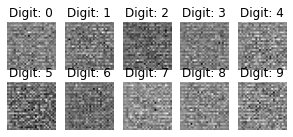

In [64]:
sample_images(generator)

## 4. Training the GAN

In [0]:
losses = []
accuracies = []
iteration_checkpoints = []
gen_checkpoints = []

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


1000 [D loss: 0.016460, acc.: 98.44%] [G loss: 6.743766]
2000 [D loss: 0.032382, acc.: 100.00%] [G loss: 1.777727]
3000 [D loss: 0.077174, acc.: 96.88%] [G loss: 5.041260]
4000 [D loss: 0.052633, acc.: 98.44%] [G loss: 3.516227]
5000 [D loss: 0.114753, acc.: 96.88%] [G loss: 3.964344]
6000 [D loss: 0.220034, acc.: 90.62%] [G loss: 6.187783]
7000 [D loss: 0.218626, acc.: 95.31%] [G loss: 4.040413]
8000 [D loss: 0.070484, acc.: 98.44%] [G loss: 2.687992]
9000 [D loss: 0.365218, acc.: 82.81%] [G loss: 1.979905]
10000 [D loss: 0.223118, acc.: 92.19%] [G loss: 2.777710]
11000 [D loss: 0.263987, acc.: 90.62%] [G loss: 2.750853]
12000 [D loss: 0.114150, acc.: 98.44%] [G loss: 4.127706]


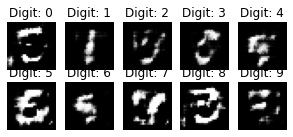

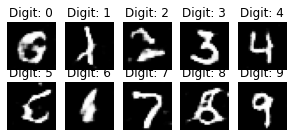

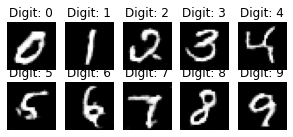

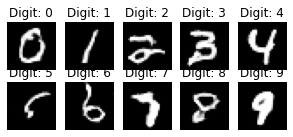

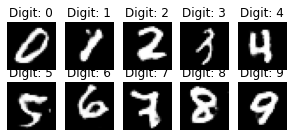

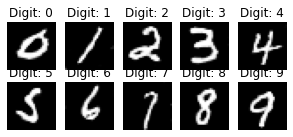

In [66]:
iterations = 12000
batch_size = 32
print_interval = 1000
sample_interval = 2000

train(iterations, batch_size, print_interval, sample_interval)

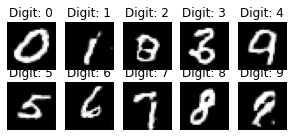

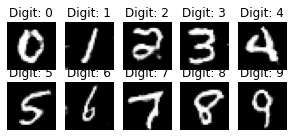

In [70]:
sample_images(generator)
sample_images(generator)

## 5. Saving the trained model

In [0]:
# Download Generator model
generator.save('mnist_generator_model.h5')

# Download Discriminator model
discriminator.save('mnist_discriminator_model.h5')